## 1. Import libraries

In [1]:
#%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.227 🚀 Python-3.11.5 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1650, 3906MiB)
Setup complete ✅ (12 CPUs, 13.5 GB RAM, 73.9/196.6 GB disk)


In [2]:
import os
import numpy as np
import timm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from PIL import Image

## 2. Load model

### 2.1 Load YOLO

In [3]:
from ultralytics import YOLO

text_det_model_path = 'models/yolov8/detect/train/weights/best.pt'
yolo = YOLO(text_det_model_path)  

### 2.2 Load CRNN
Các bạn lựa chọn kiến trúc CRNN đúng với phiên bản của file model

In [4]:
chars = '0123456789abcdefghijklmnopqrstuvwxyz-'
vocab_size = len(chars)
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [5]:
# Phiên bản ResNet CRNN
class CRNN(nn.Module):
    def __init__(
        self, 
        vocab_size, 
        hidden_size, 
        n_layers, 
        dropout=0.2, 
        unfreeze_layers=3
    ):
        super(CRNN, self).__init__()

        # Khởi tạo pretrained model resnet101
        backbone = timm.create_model(
            'resnet101', 
            in_chans=1,
            pretrained=True
        )
        # Bỏ đi lớp classifer gốc của pretrained 
        modules = list(backbone.children())[:-2]
        # Thêm vào lớp AdaptiveAvgPool2d
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        # Mở băng (unfreeze) một số layers cuối cùng của pretrained model
        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.requires_grad = True
        
        # Layer dùng để map từ CNN features maps sang LSTM 
        self.mapSeq = nn.Sequential(
            nn.Linear(2048, 1024),  
            nn.ReLU(),
            nn.Dropout(dropout)
        )
    
        self.lstm = nn.LSTM(
            1024, hidden_size, 
            n_layers, bidirectional=True, batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2)  
        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size),  
            nn.LogSoftmax(dim=2)  
        )

    def forward(self, x):
        x = self.backbone(x) # shape: (bs, c, h, w)
        x = x.permute(0, 3, 1, 2) # shape: (bs, w, c, h)
        x = x.view(x.size(0), x.size(1), -1)  # Remove h: (bs, w, c)
        x = self.mapSeq(x) 
        x, _ = self.lstm(x)
        x = self.layer_norm(x)
        x = self.out(x) # shape: (bs, seq_len, n_classes)
        x = x.permute(1, 0, 2) # Based on CTC # (seq_len, bs, n_classes)
         
        return x
    
hidden_size = 256
n_layers = 2
dropout_prob = 0.2
unfreeze_layers=3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_path = 'models/ocr_crnn_resnet_best.pt'

crnn_model = CRNN(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
    unfreeze_layers=unfreeze_layers
).to(device)
crnn_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [6]:
# Phiên bản CRNN gốc
# class CRNN(nn.Module):
#     def __init__(
#         self, 
#         in_channels,
#         vocab_size,
#         hidden_size,
#         n_layers,
#         dropout=0.2
#     ):
#         super(CRNN, self).__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2, 2)
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2, 2)
#         ) 

#         self.conv3 = nn.Sequential(
#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d((2, 2), (2, 1), (0, 1))
#         )
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d((2, 2), (2, 1), (0, 1))
#         )
#         self.conv5 = nn.Sequential(
#             nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=0),
#             nn.ReLU(inplace=True),
#         )
        
#         self.mapSeq = nn.Linear(512, 64)
        
#         self.lstm = nn.LSTM(
#             64, hidden_size,
#             num_layers=n_layers,
#             bidirectional=True,
#             dropout=dropout if n_layers > 1 else 0
#         )
#         #self.dropout = nn.Dropout(dropout)
#         self.out = nn.Sequential(
#             nn.Linear(hidden_size * 2, vocab_size),  
#             nn.LogSoftmax(dim=2) 
#         )
                                  
                                  
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)         
#         x = self.conv3(x)
#         x = self.conv4(x)
#         x = self.conv5(x)  
#         batch, channel, height, width = x.size()
#         x = x.view(batch, channel * height, width)
#         x = x.permute(2, 0, 1)
#         x = self.mapSeq(x)
#         x, _ = self.lstm(x)
#         #x = self.dropout(x)
#         x = self.out(x)
        
#         return x 
    
# in_channels = 1
# hidden_size = 256
# n_layers = 2
# dropout_prob = 0.2
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model_path = 'models/ocr_crnn_plain_best.pt'

# crnn_model = CRNN(
#     in_channels=in_channels,
#     vocab_size=vocab_size,
#     hidden_size=hidden_size,
#     n_layers=n_layers,
#     dropout=dropout_prob
# ).to(device)
# crnn_model.load_state_dict(torch.load(model_path))

## 3. Inference

In [7]:
def decode(encoded_sequences, idx_to_char, blank_char='-'):
    """
    Decode encoded label thành string
    
    Parameters:
        encoded_sequences (list): Danh sách các tensor label.
        idx_to_char (dict): Bảng mapping ID -> classname.
        blank_char (str): Kí tự "blank".
        
    Returns:
        decoded_sequences (list): danh sách các label đã được decode.
    """
    # Khai báo list rỗng chứa kết quả decode 
    decoded_sequences = []

    # Duyệt qua từng encoded label 
    for seq in encoded_sequences:
        # Khai báo list rỗng chứa từng kí tự đã decode
        decoded_label = []
        # Duyệt qua từng token 
        for idx, token in enumerate(seq):
            # Bỏ qua token padding (ID=0)
            if token != 0:
                # Lấy kí tự của token đang xét trong idx_to_char
                char = idx_to_char[token.item()]
                # Bỏ qua kí tự "blank"
                if char != blank_char:
                    decoded_label.append(char)
        # Thêm chuỗi đã decode vào list decoded_sequences
        decoded_sequences.append(''.join(decoded_label))

    return decoded_sequences

In [8]:
def text_detection(img_path, text_det_model):
    """
    Xác định vị trí (bbox) các text có trong ảnh.
    
    Parameters:
        img_path (str): Path đến file ảnh.
        text_det_model (YOLO): Model YOLO text detection.
        
    Returns:
        tuple: Bao gồm các thành phần đã xác định được (bboxes, classes, names, confs)
    """
    # Thực hiện detection theo YOLO
    text_det_results = text_det_model(img_path, verbose=False)[0]
    
    # Lấy thông tin bboxes (format xyxy)
    bboxes = text_det_results.boxes.xyxy.tolist()
    # Lấy tên classes, confidence scores
    classes = text_det_results.boxes.cls.tolist()
    names = text_det_results.names
    confs = text_det_results.boxes.conf.tolist()
    
    return bboxes, classes, names, confs

In [9]:
def text_recognition(img, data_transforms, text_reg_model, idx_to_char, device):
    """
    Nhận diện văn bản trong ảnh.
    
    Parameters:
        img (PIL.Image): Object ảnh.
        data_transforms (transforms.Compose): Hàm tiền xử lý ảnh.
        text_reg_model (CRNN): Model CRNN text recognition.
        idx_to_char (dict): Bảng mapping ID->classname.
        device (str): 'cpu' hoặc 'gpu'.
        
    Returns:
        text (str): Văn bản nhận diện được.
    """
    transformed_image = data_transforms(img)
    transformed_image = transformed_image.unsqueeze(0).to(device)
    text_reg_model.eval()
    with torch.no_grad():
        logits = text_reg_model(transformed_image).detach().cpu()
    text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)
    
    return text

In [10]:
def visualize_detections(img, detections):
    """
    Visualize kết quả Scene Text Recognition (STR).
    
    Parameters:
        img (PIL.Image): Object ảnh.
        detections (list): Danh sách kết quả STR trên ảnh.
    """
    # Cài đặt khung hình
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')

    # Duyệt qua từng (bbox, classname, conf, text)
    for bbox, detected_class, confidence, transcribed_text in detections:
        x1, y1, x2, y2 = bbox
        # Vẽ bbox và text đã nhận diện
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2))
        plt.text(
            x1, y1 - 10, f"{detected_class} ({confidence:.2f}): {transcribed_text}", 
            fontsize=9, bbox=dict(facecolor='red', alpha=0.5)
        )

    plt.show()

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((100, 420)), 
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.Grayscale(num_output_channels=1),
        transforms.GaussianBlur(3),
        transforms.RandomAffine(degrees=1, shear=1),  
        transforms.RandomPerspective(distortion_scale=0.2, p=0.3, interpolation=3),  
        transforms.RandomRotation(degrees=2),
        transforms.ToTensor(),  
        transforms.Normalize((0.5,), (0.5,)), 
    ]),
    'val': transforms.Compose([
        transforms.Resize((100, 420)), 
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),  
        transforms.Normalize((0.5,), (0.5,)), 
    ]),
}

def predict(img_path, data_transforms, text_det_model, text_reg_model, idx_to_char, device, visualize=True):
    """
    Thực hiện Scene Text Recognition với một ảnh bất kỳ.
    
    Parameters:
        img_path (str): Path đến file ảnh.
        data_transforms (transforms.Compose): Hàm tiền xử lý dữ liệu ảnh.
        text_det_model (YOLO): Model YOLO text detection.
        text_reg_model (CRNN): Model CRNN text recognition.
        idx_to_char (dict): Bảng mapping idx->classname.
        device (str): 'cpu' hoặc 'gpu'.
        visualize (bool): Kích hoạt visualize kết quả STR.
        
    Returns:
        predictions (list): Danh sách các kết quả STR trên ảnh.
    """
    # Thực hiện text detection
    bboxes, classes, names, confs = text_detection(img_path, text_det_model)

    # Load ảnh
    img = Image.open(img_path)
    
    # Khai báo list rỗng để chứa kết quả STR
    predictions = []

    # Duyệt qua từng kết quả detection
    for bbox, cls, conf in zip(bboxes, classes, confs):
        x1, y1, x2, y2 = bbox # Lấy tọa độ bbox
        confidence = conf # Lấy confidence score
        detected_class = cls # Lấy mã ID của class 
        name = names[int(cls)] # Lấy tên class theo mã ID

        # Cắt ảnh theo bbox
        cropped_image = img.crop((x1, y1, x2, y2))
        
        # Thực hiện text recognition trên ảnh đã cắt
        transcribed_text = text_recognition(
            cropped_image,
            data_transforms,
            text_reg_model,
            idx_to_char,
            device
        )

        # Thêm kết quả STR vào list predictions
        predictions.append((bbox, name, confidence, transcribed_text))
        
    # Thực hiện visualize kết quả STR nếu có
    if visualize:
        visualize_detections(img, predictions)
    
    return predictions

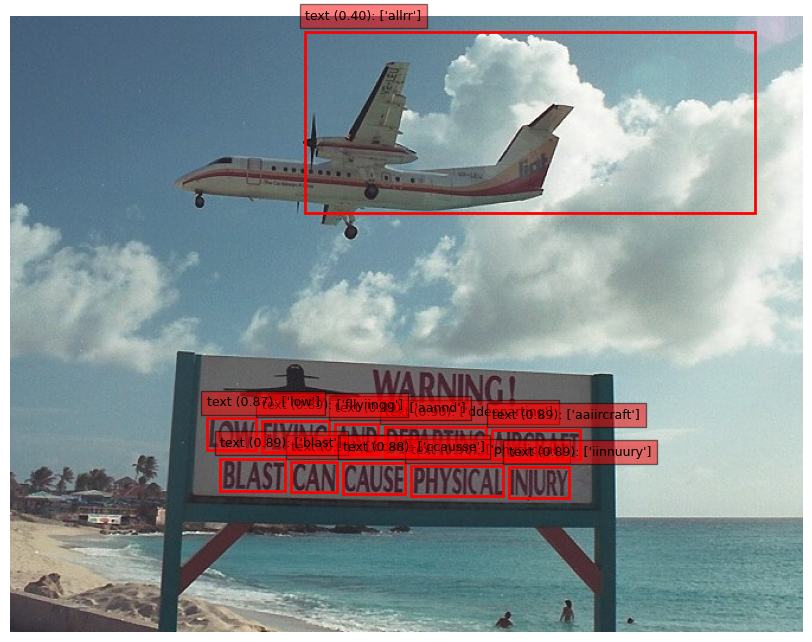

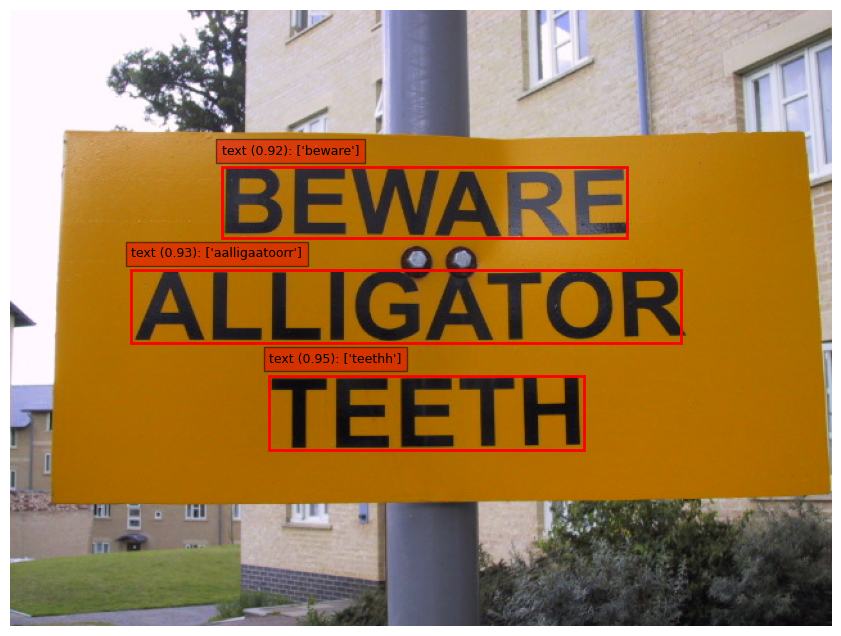

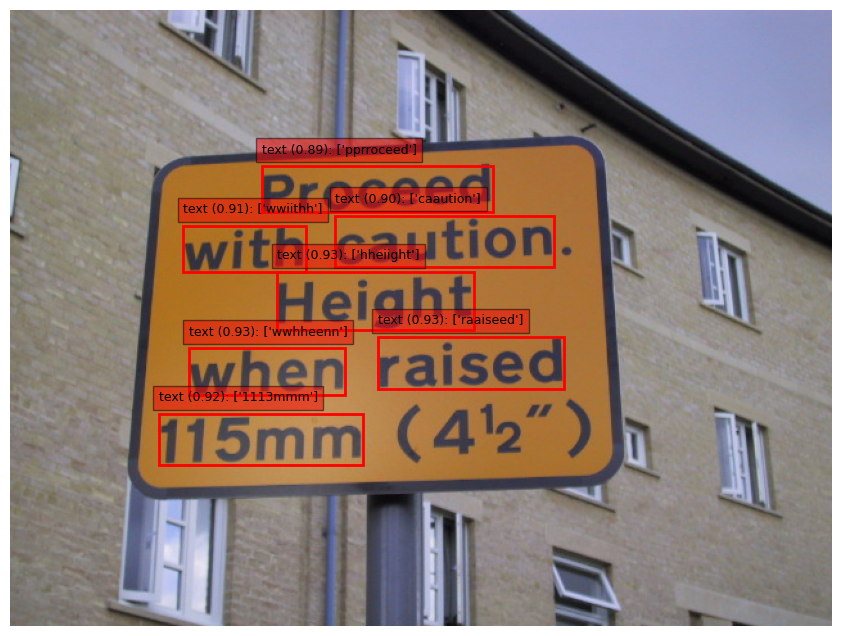

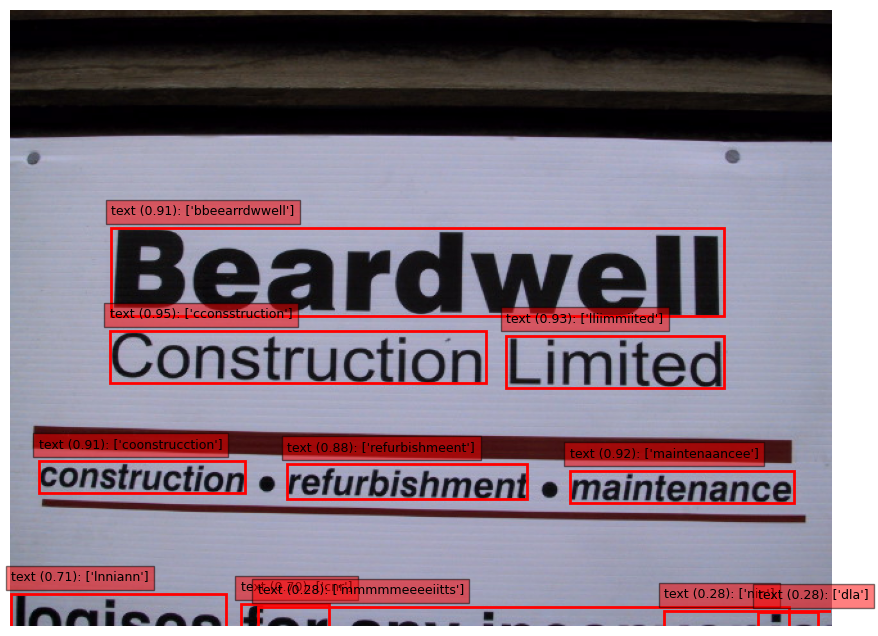

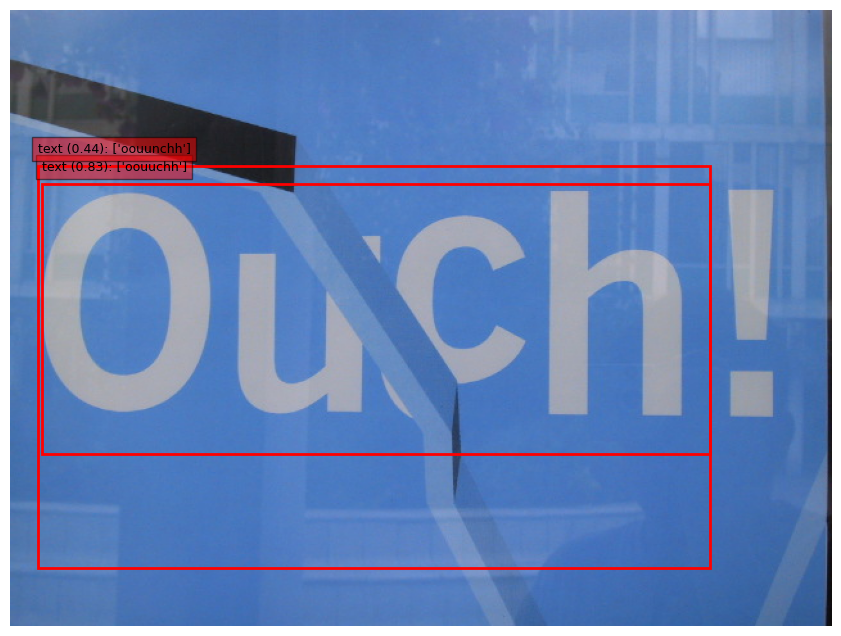

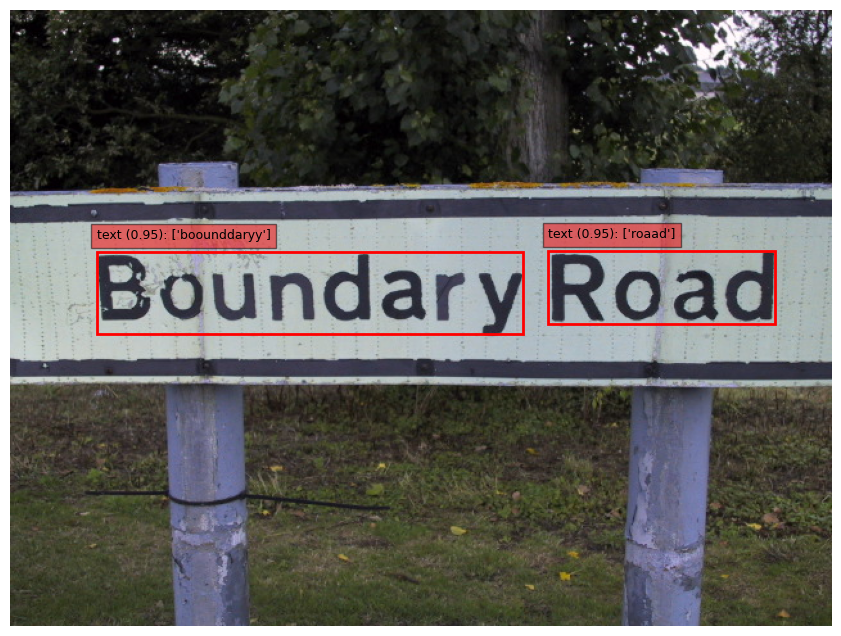

KeyboardInterrupt: 

In [12]:
# Thực hiện lời gọi hàm predict() trên các ảnh của bộ IC03
img_dir = 'data/SceneTrialTrain/lfsosa_12.08.2002'
inf_transforms = data_transforms['val']

for img_filename in os.listdir(img_dir):
    img_path = os.path.join(img_dir, img_filename)
    predictions = predict(
        img_path, 
        data_transforms=inf_transforms, 
        text_det_model=yolo, 
        text_reg_model=crnn_model, 
        idx_to_char=idx_to_char,
        device=device,
        visualize=True
    )